In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *
from netgen.meshing import Mesh as NGMesh
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Import mesh and gridfunction from 4_MagVekPot_HomCoil.ipynb

# Load mesh
ngmesh = NGMesh()
ngmesh.Load("results/homo/mesh_homo.vol")
mesh = Mesh(ngmesh)

# Load Gridfunction and B
order = 2
V = HCurl(mesh, order=order-1, nograds=True, dirichlet="outer")
gfA = GridFunction(V)
gfA.Load("results/homo/gfA_homo.vec")
B = curl(gfA)

In [3]:
# Konstanten
q_e = -1.602176634e-19  # Elektronenladung [C]
m_e = 9.10938356e-31    # Elektronenmasse [kg]

# Parameter außerhalb der Funktionen
dt = 1e-16               # Zeitschritt [s]
dt_safety = 1e-14
tolerance_z = 7.5e-4       # Toleranz um z=0
v0_min = 106000000              # Minimale Geschwindigkeit für Suche [m/s]
v0_max = 129000000           # Maximale Geschwindigkeit für Suche [m/s]
# v0_min = 117007910
# v0_max = v0_min+1
v_tolerance = 1e-6       # Toleranz für Geschwindigkeitssuche [m/s]
progress_step = 10000     # Fortschrittsanzeige alle x Schritte

v0_min_list = []
v0_max_list = []
midpoint_list = []
diff_list = []


# Magnetfeldinterpolation
def magnetic_field(position):
    x, y, z = position
    point = mesh(x, y, z)
    B_at_point = B(point) 
    return np.array([B_at_point[0], B_at_point[1], B_at_point[2]])

# Bewegungsgleichung
def rhs(t, state):
    pos = state[:3]
    vel = state[3:]
    B_vec = magnetic_field(pos)  # Magnetfeld an aktueller Position
    acc = (q_e / m_e) * np.cross(vel, B_vec)  # Lorentzkraft: a = (q/m) * (v x B)
    return np.hstack((vel, acc))

# Runge-Kutta 4. Ordnung
def runge_kutta_4(state, dt, t):
    k1 = dt * rhs(t, state)
    k2 = dt * rhs(t + dt / 2, state + k1 / 2)
    k3 = dt * rhs(t + dt / 2, state + k2 / 2)
    k4 = dt * rhs(t + dt, state + k3)
    return state + (k1 + 2 * k2 + 2 * k3 + k4) / 6

# Dynamische Anpassung des Zeitschritts
def dynamic_dt(state, tolerance_z, dt_min=1e-19, dt_max=1e-15, factor=0.9):
    """
    Adjusts the time step size dynamically based on the distance of the state from a reference point.

    Parameters:
    state (list or array-like): The current state of the system, where state[2] represents the z-coordinate.
    tolerance_z (float): The tolerance value for the z-coordinate. If the distance is less than this value, the time step is adjusted.
    dt_min (float, optional): The minimum allowable time step size. Default is 1e-18.
    dt_max (float, optional): The maximum allowable time step size. Default is 1e-16.
    factor (float, optional): A scaling factor for adjusting the time step size. Default is 0.9.

    Returns:
    float: The adjusted time step size.
    """
    distance = abs(state[2])  # Entfernung von z = 0
    if distance < tolerance_z*100: 
        return max(dt_min, factor * dt_max * (distance / tolerance_z))
    else:
        return dt_max
    
# Simulation der Elektronenbahn
def simulate_trajectory(s0, v0_z):
    """
    Simulates the trajectory of an electron starting at a given initial position and velocity.
    Parameters:
    s0 (array-like): Initial position of the electron as a 3-element array [x, y, z].
    v0_z (float): Initial velocity of the electron in the z-direction.
    Returns:
    tuple: A tuple containing:
        - trajectory (numpy.ndarray): Array of positions of the electron at each time step.
        - success (bool): True if the electron successfully reverses direction without crossing z=0, False otherwise.
        - reason (str): A string indicating the reason for the simulation ending. (overshoot, direction, success)
    The function uses a Runge-Kutta 4th order method to integrate the electron's motion over time. The simulation continues until one of the following conditions is met:
    - The electron reaches a position within a specified tolerance of z=0.
    - The electron crosses z=0.
    - The electron changes direction without reaching z=0.
    The function includes a safety check to ensure that the electron reverses direction correctly when it reaches z=0. If the electron successfully reverses direction, the function returns the trajectory and a success flag set to True. Otherwise, it returns the trajectory and a success flag set to False.
    """
    state = np.hstack((s0, [0, 0, v0_z]))  # Initialposition und -geschwindigkeit Elektron startet bei negative z mit positive z-Geschwindigkeit
    initial_state = np.copy(state)
    trajectory = [state[:3]]  # Liste der Positionen
    t = 0  # Startzeit
    safety_check_iterations = 100000 # Anzahl der Schritte, um sicherzustellen, dass das Elektron nicht weiterfliegt

    while True:
        dt = dynamic_dt(state, tolerance_z, dt_min=1e-19, dt_max=1e-13)
        
        state = runge_kutta_4(state, dt, t)  # RK4-Integration
        trajectory.append(state[:3])
        t += dt

        # TEST 
        #state = np.hstack(([0,0,-0.2], [0, 0, -34])) # Test: Elektron ändert geschwindigkeit ohne z=0 zu erreichen
        #state = np.hstack(([0,0,-0.2], [0, 0, 34])) # Test: Elektron fliegt über z=0 hinaus
        #state = np.hstack(([0,0,-0.000003], [0, 0, 0])) # Test: Elektron erreicht z=0 (Toleranz)
        
        # Feedback: Drucke Fortschritt
        if len(trajectory) % progress_step == 0:
            print(f"Zeit: {t:.2e}s | Position: {state[:3]} | Geschwindigkeit: {state[3:]}, t: {t}, dt: {dt}")

        # Abbruchbedingungen
        if abs(state[2]) <= tolerance_z:  # Elektron erreicht tolleranz um z=0
            print(f"!!! - Elektron erreicht z=0 (Toleranz) um. Letzte Position: {state[:3]}, Geschwindigkeit: {state[3:]} , t: {t}, dt: {dt}")
            print(f"Sicherheitsüberprüfung")
            
            safety_i = 0
            
            # Probiere  um sicherzustellen, dass das Elektron nicht weiterfliegt sondern umkehrt, heisst:
            # 1. position in z überschreitet nicht die Toleranz ->  status[2] < tolernace_z
            # 2. neue geschwidigkeit wird negativer                  ->  old_status[5] > new_status[5]
            while state[2] < tolerance_z:
                
                dt = dt_safety # Kleinerer Zeitschritt
                
                old_state = state # Speichere alten Zustand
                
                # Neue Position berechnen
                state = runge_kutta_4(state, dt, t)
                trajectory.append(state[:3])
                t += dt
                
                # Position und Geschwindigkeit Differenz
                #position_change = old_state[:3] - abs(state[:3]) 
                #velocity_change = old_state[3:] - abs(state[3:]) 
                
                # Feedback: Drucke Fortschritt
                # if safety_i % 100000 == 0: 
                #     #print("Safety check - ", safety_i, "Position change: ", position_change[2], "Geschwindigkeit change: ", velocity_change[2])
                #     print(f"Safety Check.    Position: {state[2]}, Geschwindigkeit: {state[5]} ")
                
                # Elektron fliegt weiter über z=0 hinaus                                -> Negativer Abbruch
                if state[2] > tolerance_z: 
                    print(f"Safety Check - Elektron fliegt über z=0 hinaus. Position: {state[2]}, Geschwindigkeit: {state[5]} ")
                    return np.array(trajectory), False, "overshoot"
                
                # Neue geschwidigkeit wird negativer 
                # # #TODO check if needed 
                # elif state[5] < 0: 
                #     safety_i += 1
                #     print("enter")
                #     continue                                                       
                # Elektron hat erfolgreich umgekehrt wenn er wieder eine Position in z überschreitet (bspw. initial_state[2] + 0.04 = -0.01)
                # position ist negativer
                # && 
                # geschwindigkeit ist negativ                                           ->  Positiver Abbruch
                elif state[2] < (initial_state[2] + 0.02) and state[5] < 0: 
                    print(f"Safety Check - Elektron hat erfolgreich umgekehrt. Position: {state[:3]}, Geschwindigkeit: {state[3:]}")
                    return np.array(trajectory), True, "success"

        # Elektron fliegt weiter über z=0 hinaus                                        -> Negativer Abbruch
        elif state[2] > tolerance_z: 
            print(f"Elektron fliegt über z=0 hinaus. Position: {state[:3]}, Geschwindigkeit: {state[3:]}, t: {t}, dt: {dt}")
            return np.array(trajectory), False, "overshoot"
        
        # Elektron ändert Richtung bzw. Geschwindigkeit in z, ohne z=0 zu erreichen     -> Negativer Abbruch
        elif state[5] < 0: 
            print(f"Elektron ändert Richtung, ohne z=0 zu erreichen. Position: {state[:3]}, Geschwindigkeit: {state[3:]}, t: {t}, dt: {dt}")
            return np.array(trajectory), False, "direction"

# Suche nach der Anfangsgeschwindigkeit
def find_v0_z(s0):
    """
    Finds the initial velocity v0_z that results in an electron reversing direction at z=0.

    This function uses a binary search algorithm to find the initial velocity v0_z within a specified tolerance.
    It simulates the trajectory of an electron and adjusts the velocity bounds based on whether the electron
    reverses direction at z=0 or not.

    Parameters:
    s0 (float): The initial position of the electron.

    Returns:
    tuple: A tuple containing the found velocity v0_z (float), the trajectory (list), and a boolean indicating
           whether the velocity was found within the tolerance (True) or not (False).
    """
    global v0_min, v0_max
    iteration = 0

    
    while v0_max - v0_min > v_tolerance:
        iteration += 1
        v0_z = (v0_min + v0_max) / 2 
        print(f"Iteration {iteration}: Teste Geschwindigkeit v0_z = {v0_z:.3f} m/s", "  Position: ", s0)
        trajectory, success = simulate_trajectory(s0, v0_z)

        if success:  # Elektron kehrt bei z=0 um
            print(f"Geschwindigkeit {v0_z:.3f} m/s könnte passen (Elektron kehrt um).")
            v0_max = v0_z  # Erhöhe Oberegrenze
            break
        else:
            print(f"Geschwindigkeit {v0_z:.3f} m/s passt nicht (Richtung geändert oder fliegt über z=0 hinaus).")
            v0_min = v0_z  # Erhöhe Untergrenze
    if not (v0_max - v0_min > v_tolerance):
        print(f"---- Abbruch: Toleranz Geschwindigkeit: {v_tolerance} erreicht ----")
        return v0_z, trajectory, True
    else:
        print(f"Gefundene Geschwindigkeit: {v0_z:.3f} m/s")
        return v0_z, trajectory, False 

# Grobrastersuche, um bessere Startwerte zu finden
def coarse_search(s0, v0_min, v0_max, step):
    print("Starte Grobrastersuche...")
    for v in np.arange(v0_min, v0_max, step):
        print(f"Teste Geschwindigkeit: {v:.3f} m/s")
        _, success = simulate_trajectory(s0, v)
        if success:
            print(f"Grobrastersuche erfolgreich: Startwert gefunden bei v = {v:.3f} m/s")
            return v
    print("Grobrastersuche hat keine Lösung gefunden.")
    return None

# Suche nach der Anfangsgeschwindigkeit
def find_v0_z_with_raster(s0):
    global v0_min, v0_max
    step = (v0_max - v0_min) / 1e2  # Schrittweite für Raster-Suche
    print(f"Starte Geschwindigkeitssuche mit Raster-Suche (Schrittweite: {step:.3f} m/s, v0_min: {v0_min:.3f} m/s, v0_max: {v0_max:.3f} m/s)")
    v_start = coarse_search(s0, v0_min, v0_max, step)

    if v_start is not None:
        v0_min = v_start / 2
        v0_max = v_start * 2

    return find_v0_z(s0)

def find_v0_z_adaptive(s0):
    """
    Finds an initial velocity v0_z that results in an electron reversing direction at z=0,
    by adaptively modifying the velocity based on overshoot or premature direction change.

    Returns (v0_z, trajectory, success).
    """
    global v0_min, v0_max  # If you still want to keep track of some global bounds
    iteration = 0
    max_iterations = 50
    
    # Start with the midpoint or any initial guess
    v0_z = 0.5*(v0_min + v0_max)
    # Step size: for instance, 1/100 of the initial range
    step = 0.1 * (v0_max - v0_min)
    
    best_trajectory = None
    found_success = False
    
    while iteration < max_iterations:
        iteration += 1
        print(f"Iteration {iteration}: Teste Geschwindigkeit v0_z = {v0_z:.3f} m/s")
        
        trajectory, success, reason = simulate_trajectory(s0, v0_z)
        
        if success and reason == "success":
            print(f">>> Erfolg! Passende Geschwindigkeit gefunden: {v0_z:.3f} m/s")
            best_trajectory = trajectory
            found_success = True
            break
        else:
            # If no success, see why we failed
            if reason == "overshoot":
                # Velocity too high -> reduce velocity
                v0_z -= step
                print("    -> Overshoot: reducing velocity.")
            elif reason == "direction":
                # Velocity too low -> increase velocity
                v0_z += step
                print("    -> Changed direction prematurely: increasing velocity.")
            else:
                # Should not happen, but just in case
                print("    -> Unexpected reason, do something else...")

            # Optionally shrink step after each iteration to hone in
            step *= 0.5

            # Check if step is smaller than your desired velocity tolerance
            # if step < v_tolerance:
            #     print(f"Step size < velocity tolerance ({v_tolerance}). Stopping search.")
            #     break

            # Also keep v0_z in some bounds to avoid going too negative or too large
            if v0_z < 0:
                v0_z = 0.5 * (v0_min + v0_max)
                print("    -> v0_z negative, resetting to midpoint!")
            if v0_z > 1.1 * v0_max:
                v0_z = 0.5 * (v0_min + v0_max)
                print("    -> v0_z too large, resetting to midpoint!")
    
    # After the loop
    return v0_z, best_trajectory, found_success

def find_v0_z_bracket(s0):
    """
    Finds an initial velocity v0_z that results in the electron reversing around z=0,
    by bracketing the velocity between v0_min and v0_max.

    Adjust the global variables:
        v0_min, v0_max (starting bracket)
        v_tolerance (stop if bracket is smaller than this)
    as needed.

    Returns (v0_z, best_trajectory, found_success).
    """
    global v0_min, v0_max, v_tolerance
    max_iterations = 10000  # or whatever you like
    found_success = False
    best_trajectory = None
    
    for iteration in range(1, max_iterations+1):
        # Midpoint of bracket
        v0_z = 0.5 * (v0_min + v0_max)

        print(f"Iteration {iteration}: testing v0_z = {v0_z:.6f} m/s "
              f"(v_min={v0_min:.6f}, v_max={v0_max:.6f}), Difference: {v0_max - v0_min:.15f}")

        trajectory, success, reason = simulate_trajectory(s0, v0_z)

        if success and reason == "success":
            print(f">>> SUCCESS at iteration {iteration} - velocity = {v0_z:.6f} m/s")
            found_success = True
            best_trajectory = trajectory
            break
        
        elif reason == "overshoot":
            # We overshot z=0 => velocity is too high => reduce upper bound
            v0_max = v0_z
            print(f"    -> Overshoot: new v_max = {v0_max:.6f}")
        
        elif reason == "direction":
            # Changed direction too soon => velocity is too low => raise lower bound
            v0_min = v0_z
            print(f"    -> Premature direction: new v_min = {v0_min:.6f}")
        
        else:
            # Should not normally happen, but just in case
            print("    -> Unexpected reason. Check your simulate_trajectory logic.")
        
        # Check bracket size
        # if (v0_max - v0_min) < v_tolerance:
        #     print("Bracket is below velocity tolerance.")
        #     break
    
    return v0_z, best_trajectory, found_success

def find_v0_z_bracket_with_plot(s0):
    """
    Finds an initial velocity v0_z that results in the electron reversing around z=0,
    while tracking the bounds for visualization.
    """
    global v0_min, v0_max, v_tolerance
    max_iterations = 10000  # Limit iterations for practical reasons
    found_success = False
    best_trajectory = None

    for iteration in range(1, max_iterations + 1):
        # Track bounds
        v0_min_list.append(v0_min)
        v0_max_list.append(v0_max)
        midpoint = 0.5 * (v0_min + v0_max)
        midpoint_list.append(midpoint)
        diff_list.append(v0_max - v0_min)

        # Midpoint of bracket
        v0_z = midpoint
        print(f"Iteration {iteration}: testing v0_z = {v0_z:.6f} m/s "
              f"(v_min={v0_min:.6f}, v_max={v0_max:.6f}), Difference: {v0_max - v0_min:.15f}")

        trajectory, success, reason = simulate_trajectory(s0, v0_z)

        if success and reason == "success":
            print(f">>> SUCCESS at iteration {iteration} - velocity = {v0_z:.6f} m/s")
            found_success = True
            best_trajectory = trajectory
            break

        elif reason == "overshoot":
            # We overshot z=0 => velocity is too high => reduce upper bound
            v0_max = v0_z
            print(f"    -> Overshoot: new v_max = {v0_max:.6f}")

        elif reason == "direction":
            # Changed direction too soon => velocity is too low => raise lower bound
            v0_min = v0_z
            print(f"    -> Premature direction: new v_min = {v0_min:.6f}")

        # Check bracket size
        if (v0_max - v0_min) < v_tolerance:
            print("Bracket is below velocity tolerance.")
            break

    return v0_z, best_trajectory, found_success

# Startposition
s0 = np.array([0, 0.007, -0.05])  # Elektron startet bei z = -0.01

# Bestimme minimale Geschwindigkeit für Umkehr bei z = 0
#v0_z, trajectory, success = find_v0_z_with_raster(s0)
#v0_z, trajectory, success = find_v0_z(s0)
#v0_z, trajectory, success = find_v0_z_adaptive(s0)
#v0_z, trajectory, success = find_v0_z_bracket(s0)
v0_z, trajectory, success = find_v0_z_bracket_with_plot(s0)

if success:
    print(f"Benötigte Anfangsgeschwindigkeit: {v0_z:.3f} m/s")
else:
    print("Geschwindigkeit konnte nicht gefunden werden.")

Iteration 1: testing v0_z = 117500000.000000 m/s (v_min=106000000.000000, v_max=129000000.000000), Difference: 23000000.000000000000000
Elektron ändert Richtung, ohne z=0 zu erreichen. Position: [ 2.56439397e-03 -9.24409381e-05 -2.44721484e-03], Geschwindigkeit: [-1.01645131e+08 -5.89462614e+07 -1.42493715e+04], t: 5.549679901070429e-10, dt: 2.9366625308799473e-13
    -> Premature direction: new v_min = 117500000.000000
Iteration 2: testing v0_z = 123250000.000000 m/s (v_min=117500000.000000, v_max=129000000.000000), Difference: 11500000.000000000000000
!!! - Elektron erreicht z=0 (Toleranz) um. Letzte Position: [ 2.49869997e-03 -1.92158249e-05 -7.48973459e-04], Geschwindigkeit: [-1.04647061e+08 -6.26502569e+07  1.77380975e+07] , t: 5.324096586128281e-10, dt: 9.006852186866058e-14
Sicherheitsüberprüfung
Safety Check - Elektron fliegt über z=0 hinaus. Position: 0.0007500142012847773, Geschwindigkeit: 19978140.264615886 
    -> Overshoot: new v_max = 123250000.000000
Iteration 3: testing

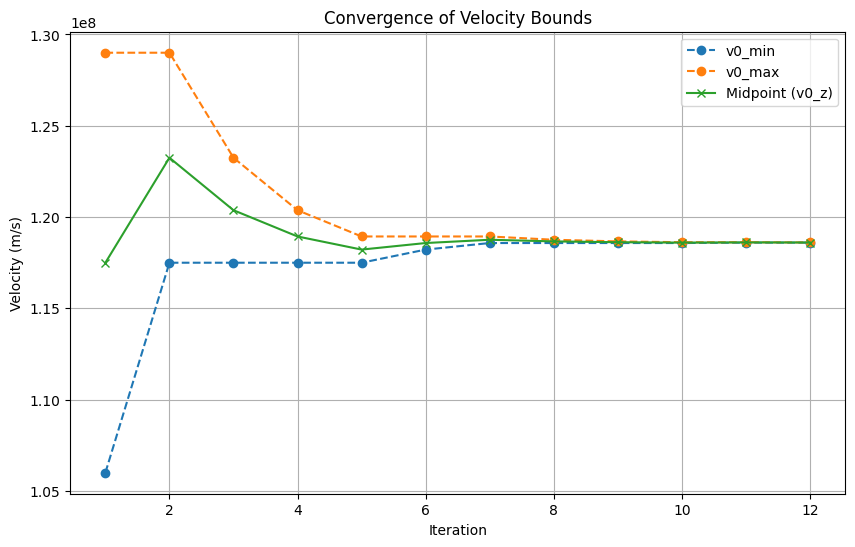

In [6]:
iterations = list(range(1, len(v0_min_list) + 1))

plt.figure(figsize=(10, 6))
plt.plot(iterations, v0_min_list, label='v0_min', linestyle='--', marker='o')
plt.plot(iterations, v0_max_list, label='v0_max', linestyle='--', marker='o')
plt.plot(iterations, midpoint_list, label='Midpoint (v0_z)', linestyle='-', marker='x')
plt.xlabel('Iteration')
plt.ylabel('Velocity (m/s)')
plt.title('Convergence of Velocity Bounds')
plt.legend()
plt.grid()
plt.show()

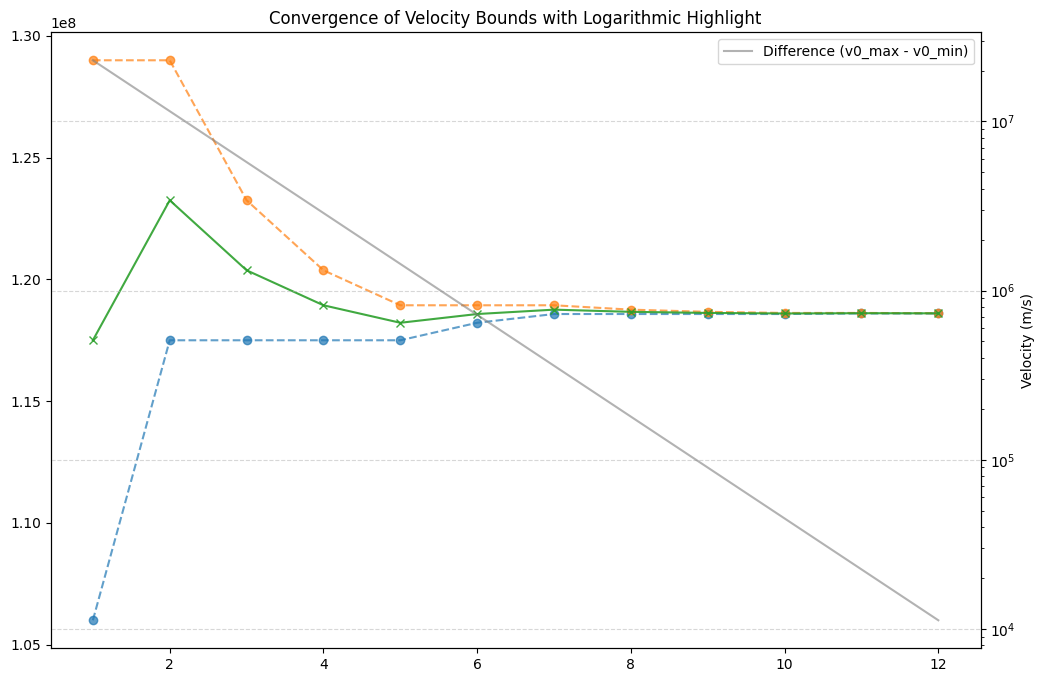

In [4]:
# Plot the results
iterations = list(range(1, len(v0_min_list) + 1))

# Create the main plot
plt.figure(figsize=(12, 8))

# Plot min, max, and midpoint velocities
plt.plot(iterations, v0_min_list, label='v0_min', linestyle='--', marker='o', alpha=0.7)
plt.plot(iterations, v0_max_list, label='v0_max', linestyle='--', marker='o', alpha=0.7)
plt.plot(iterations, midpoint_list, label='Midpoint (v0_z)', linestyle='-', marker='x', alpha=0.9)

# Highlight the difference on a log scale
plt.twinx()
plt.plot(iterations, diff_list, label='Difference (v0_max - v0_min)', linestyle='-', color='gray', alpha=0.6)
plt.yscale('log')
plt.ylabel('Logarithmic Difference (v0_max - v0_min)')

# Final formatting
plt.xlabel('Iteration')
plt.ylabel('Velocity (m/s)')
plt.title('Convergence of Velocity Bounds with Logarithmic Highlight')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [5]:
import numpy as np
import plotly.graph_objects as go

# Generate a grid for the planes
grid_size = 0.01
x = np.linspace(-grid_size, grid_size, 50)
y = np.linspace(-grid_size, grid_size, 50)
X, Y = np.meshgrid(x, y)

# Red plane at z=0
Z_red = np.zeros_like(X)

# Gray planes at z=tolerance_z and z=-tolerance_z
Z_gray1 = np.full_like(X, tolerance_z)
Z_gray2 = np.full_like(X, -tolerance_z)


# Create 3D plot
fig = go.Figure(
    layout=dict(
        title=dict(
            text="Life Expectancy",
            subtitle=dict(
                text="Life expectancy by European country in 1952 and in 2002",
                font=dict(color="gray", size=13),
            ),
        )
    ),)
fig.update_layout(width=800, height=800)

# Electron trajectory
fig.add_trace(go.Scatter3d(
    x=trajectory[:, 0],
    y=trajectory[:, 1],
    z=trajectory[:, 2],
    mode='lines',
    name='Elektronenbahn',
    line=dict(color='blue', width=4)
))

# Start point
fig.add_trace(go.Scatter3d(
    x=[s0[0]],
    y=[s0[1]],
    z=[s0[2]],
    mode='markers',
    name='Startposition',
    marker=dict(color='red', size=8)
))

# Red plane at z=0
fig.add_trace(go.Surface(
    x=X, y=Y, z=Z_red,
    showscale=False,
    opacity=0.5,
    colorscale=[[0, 'red'], [1, 'red']],
    name='z=0 Plane'
))

# Gray planes at z=tolerance_z and z=-tolerance_z
fig.add_trace(go.Surface(
    x=X, y=Y, z=Z_gray1,
    showscale=False,
    opacity=0.3,
    colorscale=[[0, 'gray'], [1, 'gray']],
    name='z=tolerance Plane'
))
fig.add_trace(go.Surface(
    x=X, y=Y, z=Z_gray2,
    showscale=False,
    opacity=0.2,
    colorscale=[[0, 'gray'], [1, 'gray']],
    name='z=-tolerance Plane'
))

# Line through the z-axis
fig.add_trace(go.Scatter3d(
    x=[0, 0],
    y=[0, 0],
    z=[-grid_size, grid_size],
    mode='lines',
    name='Z-Axis',
    line=dict(color='black', width=2, dash='dash')
))

xy_size = 0.01
z_size_min = -0.05
z_size_max = 0.01
# Update layout

title_str = f"3D Bahn des Elektrons im Magnetfeld <br><sup> Rote Ebene: z=0,    Graue Ebenen: z=±{tolerance_z} <br> Tolleranz = {tolerance_z},     v0 = {v0_z:.18} </sup>"
fig.update_layout(
    title=title_str,
    scene=dict(
        xaxis=dict(title='x [m]', range=[-xy_size, xy_size]),
        yaxis=dict(title='y [m]', range=[-xy_size, xy_size]),
        zaxis=dict(title='z [m]', range=[z_size_min, z_size_max]),
    ),
    legend=dict(x=0.1, y=0.9),
)

# Show plot
fig.show()

filename = "results/plot/" + "trajectory_tol_" + str(tolerance_z) + "_v0_" + f"{v0_z:.18}" + ".html"
fig.write_html(filename)